In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import optuna
from optuna.integration import TFKerasPruningCallback
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
import os
from PIL import Image
import cv2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def save_study(study, filename="optuna_study.pkl"):
    """Save the study to a file."""
    with open(filename, 'wb') as f:
        pickle.dump(study, f)
    print(f"Study saved to {filename}")

def load_study(filename="optuna_study.pkl"):
    """Load a study from a file."""
    try:
        with open(filename, 'rb') as f:
            study = pickle.load(f)
        print(f"Study loaded from {filename}")
        return study
    except FileNotFoundError:
        print(f"No saved study found at {filename}")
        return None

In [3]:
# Loading data
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data, dtype=object)

In [4]:
# Load data
train = get_training_data(r'C:\Users\danie\Leiden_Scripts\Datascience2025_A2\data\chest_xray\train')
test = get_training_data(r'C:\Users\danie\Leiden_Scripts\Datascience2025_A2\data\chest_xray\test')
val = get_training_data(r'C:\Users\danie\Leiden_Scripts\Datascience2025_A2\data\chest_xray\val')

# Prepare data for training
X_train = np.array([i[0] for i in train]).reshape(-1, img_size, img_size, 1)
y_train = np.array([i[1] for i in train])
X_test = np.array([i[0] for i in test]).reshape(-1, img_size, img_size, 1)
y_test = np.array([i[1] for i in test])
X_val = np.array([i[0] for i in val]).reshape(-1, img_size, img_size, 1)
y_val = np.array([i[1] for i in val])

In [5]:
def create_model(trial):
    """Create a CNN model with hyperparameters to be optimized"""
    # Hyperparameters to optimize
    n_layers = trial.suggest_int('n_layers', 2, 5)
    initial_filters = trial.suggest_int('initial_filters', 16, 64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    model = keras.Sequential()
    
    # First layer
    model.add(layers.Conv2D(initial_filters, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Additional layers
    for i in range(n_layers - 1):
        filters = initial_filters * (2 ** (i + 1))
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model, batch_size

In [6]:
def objective(trial):
    """Objective function for Optuna optimization"""
    # Create model
    model, batch_size = create_model(trial)
    
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=trial.suggest_int('rotation_range', 0, 30),
        width_shift_range=trial.suggest_float('width_shift_range', 0, 0.2),
        height_shift_range=trial.suggest_float('height_shift_range', 0, 0.2),
        horizontal_flip=trial.suggest_categorical('horizontal_flip', [True, False]),
        fill_mode='nearest'
    )
    
    # Training
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs=10,
        validation_data=(X_val, y_val),
        callbacks=[
            TFKerasPruningCallback(trial, 'val_accuracy'),
            keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
        ]
    )
    
    return history.history['val_accuracy'][-1]

In [14]:
# Try to load existing study
study = load_study()

# If no study exists, create a new one
if study is None:
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    print("Created new study")

# Run optimization with checkpointing
study.optimize(objective, n_trials=10, callbacks=[lambda study, trial: save_study(study)])


[I 2025-04-16 11:16:48,057] A new study created in memory with name: no-name-29a6a82a-39b0-490a-9c77-3398650b226e


No saved study found at optuna_study.pkl
Created new study
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - accuracy: 0.8037 - loss: 0.8317 - val_accuracy: 0.8125 - val_loss: 0.4171
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 323ms/step - accuracy: 0.8859 - loss: 0.2946 - val_accuracy: 0.6250 - val_loss: 0.8239
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 323ms/step - accuracy: 0.9004 - loss: 0.2637 - val_accuracy: 0.8750 - val_loss: 0.3383
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 331ms/step - accuracy: 0.9053 - loss: 0.2296 - val_accuracy: 0.8125 - val_loss: 0.3623
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.9145 - loss: 0.2119 - val_accuracy: 0.6875 - val_loss: 0.9299
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.9237 - loss: 0.1835 - val_accuracy: 0.8125 - val_loss: 0.3719


[I 2025-04-16 11:22:05,997] Trial 0 finished with value: 0.8125 and parameters: {'n_layers': 2, 'initial_filters': 24, 'dropout_rate': 0.49816266338196846, 'learning_rate': 0.000261338178407578, 'batch_size': 32, 'rotation_range': 30, 'width_shift_range': 0.10024926888094131, 'height_shift_range': 0.1605684899850709, 'horizontal_flip': True}. Best is trial 0 with value: 0.8125.


Study saved to optuna_study.pkl
Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 87s 261ms/step - accuracy: 0.7842 - loss: 1.4810 - val_accuracy: 0.8125 - val_loss: 0.5179
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 85s 261ms/step - accuracy: 0.8742 - loss: 0.3191 - val_accuracy: 0.5000 - val_loss: 7.4564
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 86s 265ms/step - accuracy: 0.9182 - loss: 0.2145 - val_accuracy: 0.7500 - val_loss: 0.4778
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 86s 263ms/step - accuracy: 0.8981 - loss: 0.2543 - val_accuracy: 0.5000 - val_loss: 2.3338


[I 2025-04-16 11:27:51,318] Trial 1 finished with value: 0.5 and parameters: {'n_layers': 3, 'initial_filters': 32, 'dropout_rate': 0.40400021612684867, 'learning_rate': 0.0015164417936461086, 'batch_size': 16, 'rotation_range': 12, 'width_shift_range': 0.01991184529822565, 'height_shift_range': 0.16980077959510653, 'horizontal_flip': True}. Best is trial 0 with value: 0.8125.


Study saved to optuna_study.pkl
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.7933 - loss: 3.6592 - val_accuracy: 0.8125 - val_loss: 0.4439
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8735 - loss: 0.2874 - val_accuracy: 0.6875 - val_loss: 0.6244
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8848 - loss: 0.2622 - val_accuracy: 0.6875 - val_loss: 0.6608
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9096 - loss: 0.2226 - val_accuracy: 0.7500 - val_loss: 0.5108


[I 2025-04-16 11:40:59,800] Trial 2 finished with value: 0.75 and parameters: {'n_layers': 3, 'initial_filters': 64, 'dropout_rate': 0.47864821727936946, 'learning_rate': 0.0019684066305095146, 'batch_size': 32, 'rotation_range': 20, 'width_shift_range': 0.038240396164753436, 'height_shift_range': 0.1095915786179434, 'horizontal_flip': False}. Best is trial 0 with value: 0.8125.


Study saved to optuna_study.pkl
Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 52s 155ms/step - accuracy: 0.8189 - loss: 1.5300 - val_accuracy: 0.6875 - val_loss: 0.8983
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 50s 153ms/step - accuracy: 0.9021 - loss: 0.2474 - val_accuracy: 0.9375 - val_loss: 0.2724
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 50s 153ms/step - accuracy: 0.9120 - loss: 0.2537 - val_accuracy: 0.8750 - val_loss: 0.2765
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 49s 151ms/step - accuracy: 0.9326 - loss: 0.1853 - val_accuracy: 0.6250 - val_loss: 2.5968
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 50s 154ms/step - accuracy: 0.9294 - loss: 0.2009 - val_accuracy: 0.7500 - val_loss: 0.8342


[I 2025-04-16 11:45:11,603] Trial 3 finished with value: 0.75 and parameters: {'n_layers': 2, 'initial_filters': 20, 'dropout_rate': 0.17161891842148908, 'learning_rate': 0.0012141792912308364, 'batch_size': 16, 'rotation_range': 1, 'width_shift_range': 0.13328318415389537, 'height_shift_range': 0.13111611701454023, 'horizontal_flip': True}. Best is trial 0 with value: 0.8125.


Study saved to optuna_study.pkl
Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 51s 150ms/step - accuracy: 0.7305 - loss: 2.2776 - val_accuracy: 0.8125 - val_loss: 0.6039
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 51s 157ms/step - accuracy: 0.8123 - loss: 0.4124 - val_accuracy: 0.7500 - val_loss: 0.5456
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 50s 153ms/step - accuracy: 0.8319 - loss: 0.3551 - val_accuracy: 0.8750 - val_loss: 0.3953
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 49s 151ms/step - accuracy: 0.8398 - loss: 0.3557 - val_accuracy: 0.6875 - val_loss: 0.4860
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 45s 139ms/step - accuracy: 0.8549 - loss: 0.3115 - val_accuracy: 0.6875 - val_loss: 0.8267
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 46s 140ms/step - accuracy: 0.8801 - loss: 0.2942 - val_accuracy: 0.7500 - val_loss: 0.4963


[I 2025-04-16 11:50:04,817] Trial 4 finished with value: 0.75 and parameters: {'n_layers': 3, 'initial_filters': 20, 'dropout_rate': 0.1935325219291238, 'learning_rate': 0.005912744847320742, 'batch_size': 16, 'rotation_range': 2, 'width_shift_range': 0.09319652998816984, 'height_shift_range': 0.15471590250093384, 'horizontal_flip': True}. Best is trial 0 with value: 0.8125.


Study saved to optuna_study.pkl
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.7948 - loss: 1.2022

[I 2025-04-16 11:51:22,219] Trial 5 pruned. Trial was pruned at epoch 0.


Study saved to optuna_study.pkl
Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8474 - loss: 0.4752

[I 2025-04-16 11:52:33,885] Trial 6 pruned. Trial was pruned at epoch 0.


Study saved to optuna_study.pkl
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 440ms/step - accuracy: 0.8302 - loss: 1.1229 - val_accuracy: 0.8750 - val_loss: 0.3320
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 434ms/step - accuracy: 0.9384 - loss: 0.1534 - val_accuracy: 0.8125 - val_loss: 0.2703
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 438ms/step - accuracy: 0.9466 - loss: 0.1250 - val_accuracy: 0.8125 - val_loss: 0.3401
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 434ms/step - accuracy: 0.9513 - loss: 0.1082 - val_accuracy: 0.9375 - val_loss: 0.2445
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 436ms/step - accuracy: 0.9603 - loss: 0.1002 - val_accuracy: 0.8125 - val_loss: 0.5678
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 435ms/step - accuracy: 0.9642 - loss: 0.0984 - val_accuracy: 0.8125 - val_loss: 0.2876
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 434ms/step - accuracy: 0.9603 - loss: 0.0986 - val_accuracy: 1.0000 - val_loss: 0.0194
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 436ms/s

[I 2025-04-16 12:04:33,243] Trial 7 finished with value: 1.0 and parameters: {'n_layers': 2, 'initial_filters': 32, 'dropout_rate': 0.2391642349927607, 'learning_rate': 0.0003052770523341374, 'batch_size': 32, 'rotation_range': 0, 'width_shift_range': 0.013109472122892174, 'height_shift_range': 0.06597518469009249, 'horizontal_flip': True}. Best is trial 7 with value: 1.0.


Study saved to optuna_study.pkl
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.8209 - loss: 1.2759

[I 2025-04-16 12:06:38,789] Trial 8 pruned. Trial was pruned at epoch 0.


Study saved to optuna_study.pkl
Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8290 - loss: 0.8675

[I 2025-04-16 12:08:43,998] Trial 9 pruned. Trial was pruned at epoch 0.


Study saved to optuna_study.pkl


In [16]:
# Save the final study
save_study(study)

Study saved to optuna_study.pkl


In [17]:
# Load the saved study
study = load_study()

# Print best parameters
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


# # Best trial:
#   Value: 0.875
#   Params: 
#     n_layers: 4
#     initial_filters: 28
#     dropout_rate: 0.3934239936659848
#     learning_rate: 0.0008179373408741687
#     batch_size: 64
#     rotation_range: 4
#     width_shift_range: 0.02933707456535968
#     height_shift_range: 0.11687036886534152
#     horizontal_flip: False


Study loaded from optuna_study.pkl
Best trial:
  Value:  1.0
  Params: 
    n_layers: 2
    initial_filters: 32
    dropout_rate: 0.2391642349927607
    learning_rate: 0.0003052770523341374
    batch_size: 32
    rotation_range: 0
    width_shift_range: 0.013109472122892174
    height_shift_range: 0.06597518469009249
    horizontal_flip: True


In [23]:
# Try these instead of the Plotly-based visualizations
import optuna.visualization.matplotlib as optuna_plot

# Create a figure for optimization history
plt.figure(figsize=(10, 6))
optuna_plot.plot_optimization_history(study)
plt.savefig('optimization_history.png')
plt.close()

# Create a figure for parameter importances
plt.figure(figsize=(10, 6))
optuna_plot.plot_param_importances(study)
plt.savefig('parameter_importances.png')
plt.close()

C:\Users\danie\AppData\Local\Temp\ipykernel_14388\569508573.py:6: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

C:\Users\danie\AppData\Local\Temp\ipykernel_14388\569508573.py:12: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [20]:
# Train final model with best parameters
best_params = study.best_params
model, batch_size = create_model(study.best_trial)

# Load all data
(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_training_data()

# Data augmentation with best parameters
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=best_params['rotation_range'],
    width_shift_range=best_params['width_shift_range'],
    height_shift_range=best_params['height_shift_range'],
    horizontal_flip=best_params['horizontal_flip'],
    fill_mode='nearest'
)

# Train final model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.3)
    ]
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

c:\Users\danie\Leiden_Scripts\Datascience2025_A2\datascience_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



TypeError: get_training_data() missing 1 required positional argument: 'data_dir'

In [21]:
# Import additional metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns

# Function to evaluate and plot metrics
def evaluate_model(model, x_data, y_data, title_prefix):
    # Get predictions
    y_pred = (model.predict(x_data) > 0.5).astype(int)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_data, y_pred, average='binary')
    
    # Create confusion matrix
    cm = confusion_matrix(y_data, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title_prefix} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Plot metrics
    plt.subplot(1, 2, 2)
    metrics = ['Precision', 'Recall', 'F1 Score']
    values = [precision, recall, f1]
    plt.bar(metrics, values)
    plt.title(f'{title_prefix} Metrics')
    plt.ylim(0, 1)
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification report
    print(f"\n{title_prefix} Classification Report:")
    print(classification_report(y_data, y_pred))
    
    return precision, recall, f1

# Evaluate CNN model on train and test sets
print("\nEvaluating CNN Model:")
train_metrics = evaluate_model(model, x_train, y_train, "Train")
test_metrics = evaluate_model(model, x_test, y_test, "Test")

# Load and evaluate the alternative ML model (Random Forest)
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load the saved Random Forest model
rf_model = joblib.load('../models/random_forest_model.joblib')

# Reshape data for Random Forest (flatten images)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Evaluate Random Forest model
print("\nEvaluating Random Forest Model:")
rf_train_metrics = evaluate_model(rf_model, x_train_flat, y_train, "Train")
rf_test_metrics = evaluate_model(rf_model, x_test_flat, y_test, "Test")

# Compare models
print("\nModel Comparison Summary:")
print("CNN Model:")
print(f"Train - Precision: {train_metrics[0]:.3f}, Recall: {train_metrics[1]:.3f}, F1: {train_metrics[2]:.3f}")
print(f"Test  - Precision: {test_metrics[0]:.3f}, Recall: {test_metrics[1]:.3f}, F1: {test_metrics[2]:.3f}")
print("\nRandom Forest Model:")
print(f"Train - Precision: {rf_train_metrics[0]:.3f}, Recall: {rf_train_metrics[1]:.3f}, F1: {rf_train_metrics[2]:.3f}")
print(f"Test  - Precision: {rf_test_metrics[0]:.3f}, Recall: {rf_test_metrics[1]:.3f}, F1: {rf_test_metrics[2]:.3f}")


Evaluating CNN Model:


NameError: name 'x_train' is not defined

NameError: name 'history' is not defined

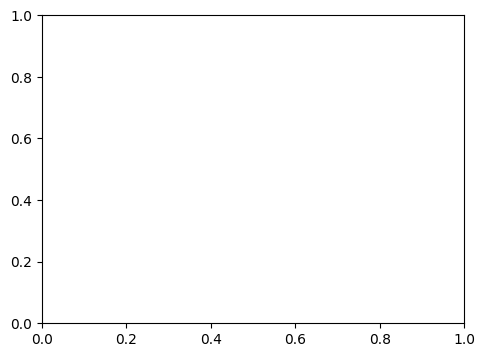

In [22]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()